<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/1-computer-vision-lab/5_Captum_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example using CAPTUM!

# Setup

In [1]:
#XAI methods
! pip install captum kaggle

     |████████████████████████████████| 1.4 MB 5.3 MB/s 


In [2]:
pip install cmapy

  Created wheel for cmapy: filename=cmapy-0.6.6-py3-none-any.whl size=3959 sha256=9063762e9f0aab886b537ff4916389d9e7a91ed1132f55d69c867acadc6a6b5b
  Stored in directory: /root/.cache/pip/wheels/49/9a/c8/486d47fd07a9ca1b91602dd040f727313dbeaa059a45d77521
Successfully built cmapy


In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import os
import sys
import urllib
import json
import random

from io import StringIO ##For images
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as transformsF
from captum.attr import IntegratedGradients
#from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution
from captum.attr import GradientShap
from captum.attr import Lime
from captum.attr import visualization as viz
#Extras for this test
import matplotlib.pyplot as plt
print(torch.__version__)
from zipfile import ZipFile
from random import randint

1.11.0+cu113


In [4]:
from torch.utils.data import Dataset
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import copy

import json

In [5]:
# Set random seed for reproducibility.
np.random.seed(131254)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Authenticate in kaggle and download dataset

### We also download the test dataset from our own repository (drive for me)

REMEMBER TO CHANGE THE API KEY!

In [8]:
#The kaggle token
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

#Here you need your kaggle api_token! 
api_token = {"username":"your_username","key":"your_KEY!"} 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download smeschke/four-shapes

 51% 11.0M/21.6M [00:00<00:00, 115MB/s]
100% 21.6M/21.6M [00:00<00:00, 166MB/s]


In [10]:
with ZipFile('/content/four-shapes.zip', 'r') as archive:
  archive.extractall('/content')


In [11]:
root_dir = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml'
data_path = "/content/data"
!unzip "/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/captum-shape-testset.zip" -d $data_path


Archive:  /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/captum-shape-testset.zip
   creating: /content/data/captum-shape-testset/
  inflating: /content/data/captum-shape-testset/.DS_Store  
  inflating: /content/data/__MACOSX/captum-shape-testset/._.DS_Store  
   creating: /content/data/captum-shape-testset/set2/
  inflating: /content/data/__MACOSX/captum-shape-testset/._set2  
   creating: /content/data/captum-shape-testset/set1/
  inflating: /content/data/__MACOSX/captum-shape-testset/._set1  
  inflating: /content/data/captum-shape-testset/set2/Bild9.PNG  
  inflating: /content/data/__MACOSX/captum-shape-testset/set2/._Bild9.PNG  
  inflating: /content/data/captum-shape-testset/set2/Bild8.PNG  
  inflating: /content/data/__MACOSX/captum-shape-testset/set2/._Bild8.PNG  
  inflating: /content/data/captum-shape-testset/set2/Bild6.PNG  
  inflating: /content/data/__MACOSX/captum-shape-testset/set2/._Bild6.PNG  
  inflating: /content/data/captum-shape-testset/set2/Bild7.PNG  
  in

## Dataloader


In [12]:
# create the annotation file for the training!

from os import listdir
from os.path import isfile, join
import csv

shape_path = "/content/shapes"

shapes_to_ignore = ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
labels_to_ignore = []

with open('/content/shapes/shapes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir("/content/shapes"):
        if dirs in labels_to_ignore: #Ignore label!
          continue

#         print(dirs)
        if(dirs.endswith(".csv")):
            continue
        for f in listdir(join("/content/shapes", dirs)):

            if f in shapes_to_ignore: #ignore the images! 
              continue
            elif(join("/content/shapes", dirs, f).endswith(".csv")):
                continue
            elif isfile(join("/content/shapes", dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [13]:
num_classes = 4
possible_labels = {"circle": 0, "square": 1, "star": 2, "triangle": 3}
#possible_labels = {"circle": 0, "square": 1, "triangle": 2}
key_list = list(possible_labels.keys())
val_list = list(possible_labels.values())

def label_to_idx(label):
  return possible_labels[label]

def idx_to_label(idx):
  position = val_list.index(idx)
  return key_list[position]

In [15]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resizer = transforms.Resize(size=(200, 200))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) # Converts to tensor
        image = image.float()
        image /= 255.
        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label_to_idx(label))

        # ADDDITIONS TO TRANSFORM THE INPUT
        r = random.random() # 33% (equal probability) to zoom-in, zoom-out, dont transform

        if r < 0.33: # We zoom-in the shape!
          top = random.randrange(0, 40) 
          left = top
          dif = 40 - top
          w = 120 + dif
          h = w
          image = transformsF.resized_crop(image, top, left, h, w, size=(200, 200))
        elif r < 0.66: # We zoom-out the shape!
          pad = random.randrange(0, 300)
          image = transforms.Pad(padding=pad, fill=1)(image)
          image = self.resizer(image)
        #else: We just use the image as is! 

        # END OF ADDITIONS!

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        image = image.repeat(3, 1, 1)
        
        return image, label

In [16]:
## dls = DataLoader
shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes')
print(len(shapes_dataset))
input, label = shapes_dataset[0]
print(type(input))
print(input.shape)
print(type(label))
print(label)


training_size = int(len(shapes_dataset)*0.9)
validation_size = int(len(shapes_dataset) - training_size)
print(training_size)
print(validation_size)
train_set, val_set = torch.utils.data.random_split(shapes_dataset, [training_size, validation_size])

training_loader = DataLoader(train_set, batch_size=64, shuffle=True)
validation_loader = DataLoader(val_set, batch_size=64, shuffle=True)



14930
<class 'torch.Tensor'>
torch.Size([3, 200, 200])
<class 'torch.Tensor'>
tensor(3)
13437
1493


# Visualize the training set! 

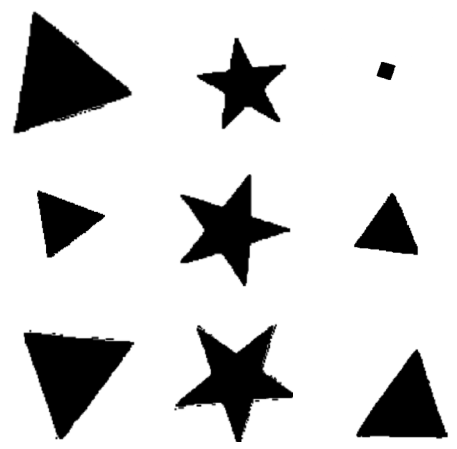

In [17]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
    sample = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    img, label = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
#    plt.imshow(img.squeeze(), cmap="gray") # if the image is grayscale
    plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
plt.show()

# TRAIN AND TEST THE MODELS! 

Change the following cell the parameter (pretrained=True) to get a pretrained model 

In [18]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
%%capture
pretrained = False
feature_extract = False #False means we retrain the whole network, True = Freeze the weights, train only the last layer
# feature extracting does not matter if pretrained=False

#Do the torch thing
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True #Skum grej från https://github.com/pytorch/pytorch/issues/61755
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=pretrained)

In [ ]:
#We change the final layer!

model_ft = model
set_parameter_requires_grad(model_ft, feature_extract) #This is done first to know if we need to freeze the already "working" part!
num_ftrs = model_ft.fc.in_features  # Get what the final layer should receive

# Here the size of each output sample is set to 4 (the shape names)
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)

In [ ]:
def train_model(model, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / training_size
    epoch_acc = running_corrects.double() / training_size

    print('train Loss: {:.4f} Acc: {:.4f}'.format(
         epoch_loss, epoch_acc))

In [ ]:
def test_model(model, criterion):
    since = time.time()
    best_acc = 0.0
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / validation_size
    epoch_acc = running_corrects.double() / validation_size

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [ ]:
num_epochs = 4

criterion = nn.CrossEntropyLoss()

# We are optimizing
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs... Not relevant if 4 epochs!
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print()
    train_model(model_ft, criterion, optimizer_ft)
    test_model(model_ft, criterion)
    scheduler.step()

Epoch 0/3

train Loss: 0.7638 Acc: 0.6582
test Loss: 0.3018 Acc: 0.9216
Epoch 1/3

train Loss: 0.1687 Acc: 0.9624
test Loss: 0.0883 Acc: 0.9913
Epoch 2/3

train Loss: 0.0882 Acc: 0.9807
test Loss: 0.0905 Acc: 0.9786
Epoch 3/3

train Loss: 0.0613 Acc: 0.9850
test Loss: 0.0268 Acc: 0.9953


In [ ]:
for epoch in range(1):
  test_model(model_ft, criterion)

test Loss: 0.0236 Acc: 0.9973


# SAVE/LOAD MODELS 

In [19]:
# Change to your paths!
testset_path="/content/data/captum-shape-testset/set1/"
model_save_path = "/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/models/CAPTUM-models/"

model_weights_no_pretrained = model_save_path + 'shapes_resnet50model_not_pretrained_weights.pth'
complete_model_no_pretrained = model_save_path + 'shapes_resnet50model_not_pretrained.pth'

In [21]:
ls -a $testset_path

./   Bild1.PNG  Bild3.PNG  Bild5.PNG  Bild7.PNG  Bild9.PNG
../  Bild2.PNG  Bild4.PNG  Bild6.PNG  Bild8.PNG


## SAVE MODELS

In [ ]:
#Save NO PRETRAINED!
torch.save(model_ft.state_dict(), model_weights_no_pretrained)
torch.save(model_ft, complete_model_no_pretrained)

In [ ]:
#Save PRETRAINED
torch.save(model_ft.state_dict(), model_weights_pretrained)
torch.save(model_ft, complete_model_pretrained)

In [ ]:
#Save PRETRAINED FREEZE WEIGHTS
torch.save(model_ft.state_dict(), model_weights_pretrained_freeze)
torch.save(model_ft, complete_model_pretrained_freeze)

## LOAD THE MODELS! 

In [20]:
#And then training the model
%%capture
#Do the torch thing
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True #Skum grej från https://github.com/pytorch/pytorch/issues/61755
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()
model

### Pretrained model

In [ ]:
%%capture
num_ftrs = model.fc.in_features # Get what the final layer should receive

# Here the size of each output sample is set to 2 (the class names)
# Create a new final layer
model.fc = nn.Linear(num_ftrs, 4)

model_ft = model
model_ft.load_state_dict(torch.load(model_weights_pretrained, map_location=torch.device(device)))
model_ft.eval()
model_ft = model_ft.to(device)

In [ ]:
model_ft = model
model_ft = torch.load(complete_model_pretrained, map_location=torch.device(device))
model_ft.eval()
model_ft = model_ft.to(device)

### Not Pretrained model

In [21]:
num_ftrs = model.fc.in_features # Get what the final layer should receive

# Here the size of each output sample is set to 2 (the class names)
# Create a new final layer
model.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model
model_ft = torch.load(complete_model_no_pretrained, map_location=torch.device(device))
model_ft.eval()
model_ft = model_ft.to(device)

In [22]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# XAI Methods - Captum


https://captum.ai/tutorials/

In [23]:
method="blended_heat_map"#"heat_map" #"blended_heat_map"
sign="positive" #positive
alpha_overlay = 0.6
default_cmap = LinearSegmentedColormap.from_list('custom green', 
                                                 [(0, '#39422c'),
                                                  (1, '#8df505')], N=5)

In [24]:
def show_image(image, prediction):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(prediction)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [25]:
from skimage import io, transform
from PIL import Image

eval_transform = transforms.Compose([
        transforms.Resize((200, 200)),
        #transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

def transform_eval_data(img_path, eval_transform = None):
  image = Image.open(img_path).convert('RGB')
  
  if eval_transform:
      image = eval_transform(image)
  image = image.float()
  return image
        

## XAI METHODS separated in Functions to be called!

In [26]:
def calculate_occlusion(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path="", save=False):

  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)

  #experiment_model.zero_grad()

  occlusion = Occlusion(experiment_model)
  
  # Usual
  attributions = occlusion.attribute(input_img,
                                    strides = (3, 25, 25),
                                    sliding_window_shapes=(3,50, 50),
                                    target=target_label,
                                    baselines = 0)

  # Remove the fake batch dimension
  input_img = input_img.squeeze()

  result = viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                              input_img.cpu().permute(1,2,0).detach().numpy(), 
                              #cmap=default_cmap,
                              alpha_overlay=alpha_overlay,
                              method=method,
                              sign=sign,
                              fig_size=(10,10))
  
  print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))
  if save:
    n=str(img_index + 1)
    result[0].savefig(save_path+'Bild'+n+ '_' + str(idx_to_label(target_label)) + '_Occ.PNG',bbox_inches='tight', pad_inches = 0)

In [27]:
def eval_model(experiment_set, test_model, print_eval=False):
  since = time.time()
  test_model.eval()   # Set model to evaluate mode

  for experiment_sample in experiment_set:
    torch.set_printoptions(sci_mode=False)

    with torch.no_grad():
      input = experiment_sample
      input = torch.unsqueeze(input, 0)
      input = input.to(device)
      #print(input.shape)
      output = test_model(input)
      _, pred = torch.max(output, 1)

      input= input.cpu().squeeze()
      smax = F.softmax(output,dim=1)
      print("prediction: ", pred, ", label: ", idx_to_label(pred))

      if print_eval:
        show_image(input.permute(1,2,0), idx_to_label(pred))
        print(smax)
        print("---------")

def get_all_files(experiment_path):
  loaded_files = []
  for f in sorted(os.listdir(experiment_path)):
    if f.endswith('.PNG') or f.endswith('.png'):
      loaded_files.append(f)
  #print(loaded_files)
  return loaded_files

def load_experiment_data(experiment_path, test_model, plot_data=False, evaluate_model=False, print_evaluation=False):
  experiment_set = []
  eval_dir = get_all_files(experiment_path)
  eval_size = len(eval_dir)
  for i in range(eval_size):
    experiment_set.append(transform_eval_data(experiment_path + eval_dir[i]
                                      ,eval_transform))
  
  if plot_data:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
        img = experiment_set[i-1] # index dataset (gets you the img and label - index)
        figure.add_subplot(rows, cols, i)
        plt.title(img.shape)
        plt.axis("off")
    #    plt.imshow(img.squeeze(), cmap="gray") # if the image is grayscale
        plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
    plt.show()
  
  if evaluate_model:
    eval_model(experiment_set, test_model, print_evaluation)

  return experiment_set

In [28]:
import pandas as pd

def process_input(input_img, experiment_model, debug=False):
  input_img = input_img.to(device)
  output = experiment_model(input_img)
  probabilities = F.softmax(output[0], dim=0)
  top_prob, top_catid = torch.topk(probabilities, num_classes)
  jsonData={}
  for i in range(top_prob.size(0)):
      prediction={}
      prob=top_prob[i].item()
      prediction["probability"] = np.round(top_prob[i].item(),9)
      prediction["label"] = idx_to_label(top_catid[i])
      prediction["labelid"] = top_catid[i].item()
      jsonData[i]=prediction
  ###
  #LH:label= top5_catid[0].item()
  #label= top_catid[0].item()
  if debug:
    #print(label,jsonData)
    print(jsonData)

  #output = model(input_img)
  #output = F.softmax(output, dim=1)
  #prediction_score, pred_label_idx = torch.topk(output, 1)
  #pred_label_idx.squeeze_()
  #predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
  #print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

  return top_catid, top_prob, jsonData

In [30]:
import json

def run_experiment_shapes(experiment_model, experiment_path, experiment_name, save_path="", label_id=0, index=-1, save=False, debug=False):
  print(experiment_name)
  experiment_set = load_experiment_data(experiment_path,  experiment_model, plot_data=False, evaluate_model = False, print_evaluation=False)
  print("------------------")
  path_to_save = save_path + experiment_name.replace(" ", "") + "/"
  print("Save Path: ", path_to_save)

  if not os.path.exists(path_to_save):
    print("this happens")
    os.makedirs(path_to_save)

  json_data = {}

  if index == -1: # Iterate all the experiment set! else only the specific index is 
    for idx, experiment_sample in enumerate(experiment_set):
      ignore_indices = []
      if idx in ignore_indices:
        continue

      experiment_sample = experiment_sample.unsqueeze(0)
      top_candidates, top_probs, jdata = process_input(experiment_sample, experiment_model, debug=debug)
      json_data[idx] = jdata
      print("Selected label: ", top_candidates[label_id] )
      print("target_label: ", top_candidates[label_id].item())

      calculate_occlusion(experiment_model, 
                              target_label=top_candidates[label_id],
                              input_img=experiment_sample,
                              top_candidates=top_candidates, top_probs=top_probs,
                              img_index=idx, save_path=path_to_save, save=save)


  else:
      experiment_sample = experiment_set[index]
      experiment_sample = experiment_sample.unsqueeze(0)

      top_candidates, top_probs = process_input(experiment_sample, experiment_model, debug=debug)
      target_label = top_candidates[label_id].item()
      print("Selected label: ", top_candidates[label_id] )
      print("target_label: ", top_candidates[label_id].item())

      calculate_occlusion(experiment_model, 
                              target_label=target_label,
                              input_img=experiment_sample,
                              top_candidates=top_candidates, top_probs=top_probs,
                              img_index=index, save_path=path_to_save, save=save)
      
  save_json = json.dumps(json_data)
  with open(path_to_save + 'label_info.json', 'w') as outfile:
    outfile.write(save_json)

## Run the experiments!

Set1 no_pret
------------------
Save Path:  random_pathSet1no_pret/
this happens
{0: {'probability': 0.994845152, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.00515141, 'label': 'square', 'labelid': 1}, 2: {'probability': 3.458e-06, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


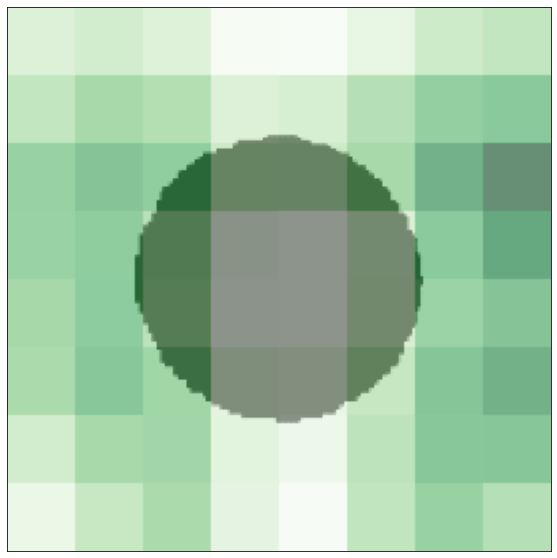

tensor(0, device='cuda:0') circle 0.99
{0: {'probability': 0.995147407, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.004137345, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.000715196, 'label': 'circle', 'labelid': 0}, 3: {'probability': 3e-08, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


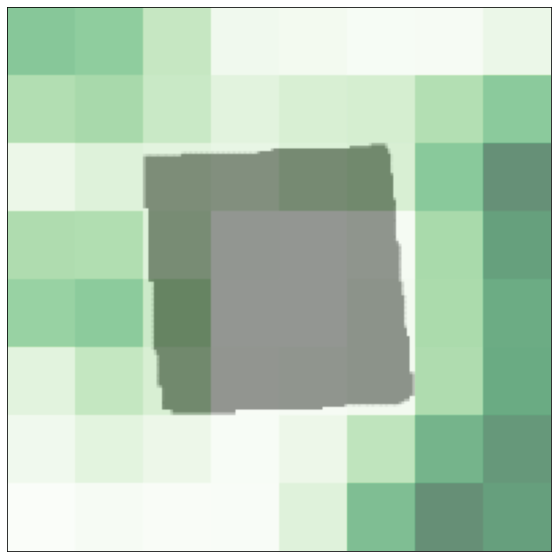

tensor(1, device='cuda:0') square 1.0
{0: {'probability': 0.999964356, 'label': 'star', 'labelid': 2}, 1: {'probability': 3.5676e-05, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


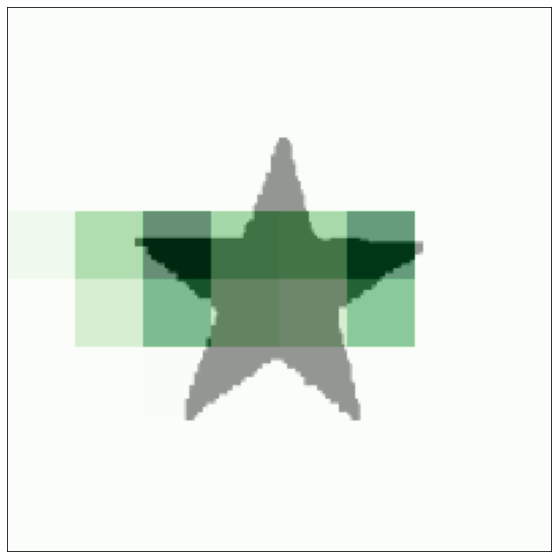

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.994516671, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.004495337, 'label': 'star', 'labelid': 2}, 2: {'probability': 0.000987968, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


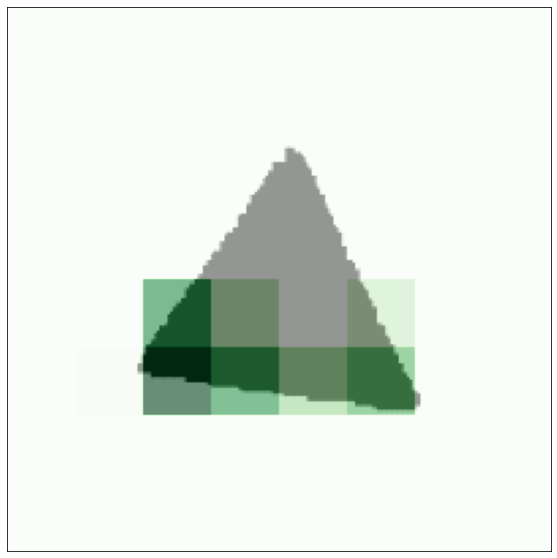

tensor(3, device='cuda:0') triangle 0.99
{0: {'probability': 0.994041264, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.005952871, 'label': 'square', 'labelid': 1}, 2: {'probability': 5.854e-06, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


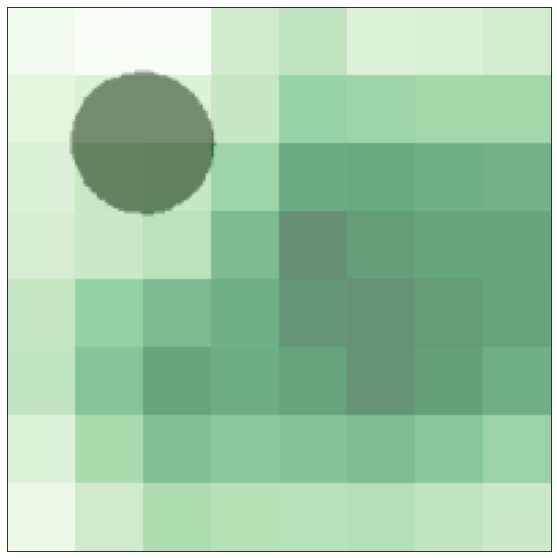

tensor(0, device='cuda:0') circle 0.99
{0: {'probability': 0.975655079, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.017554104, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.006790678, 'label': 'circle', 'labelid': 0}, 3: {'probability': 1.14e-07, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


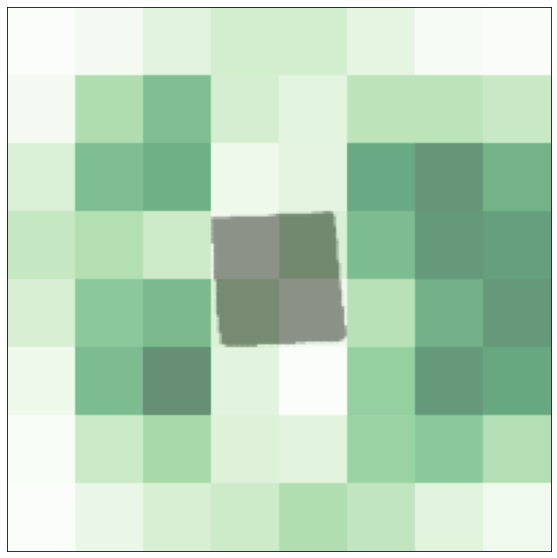

tensor(1, device='cuda:0') square 0.98
{0: {'probability': 0.869685888, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.130314171, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


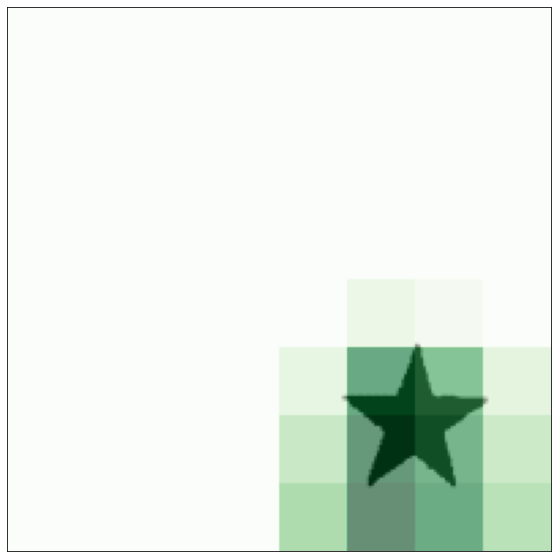

tensor(2, device='cuda:0') star 0.87
{0: {'probability': 0.984575033, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.015090598, 'label': 'star', 'labelid': 2}, 2: {'probability': 0.000334446, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


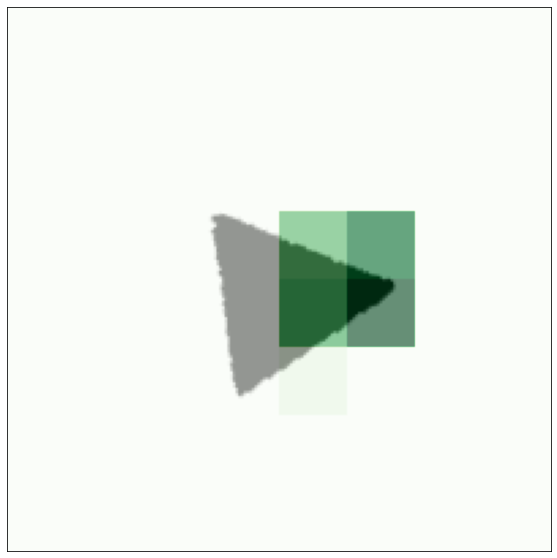

tensor(3, device='cuda:0') triangle 0.98
{0: {'probability': 0.994152486, 'label': 'triangle', 'labelid': 3}, 1: {'probability': 0.00574548, 'label': 'square', 'labelid': 1}, 2: {'probability': 0.000101506, 'label': 'star', 'labelid': 2}, 3: {'probability': 4.96e-07, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(3, device='cuda:0')
target_label:  3


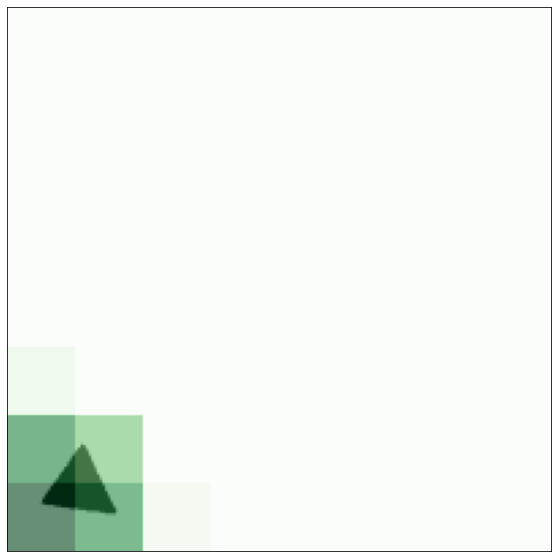

tensor(3, device='cuda:0') triangle 0.99
Set2 no_pret
------------------
Save Path:  random_pathSet2no_pret/
this happens
{0: {'probability': 0.999999404, 'label': 'star', 'labelid': 2}, 1: {'probability': 6.4e-07, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


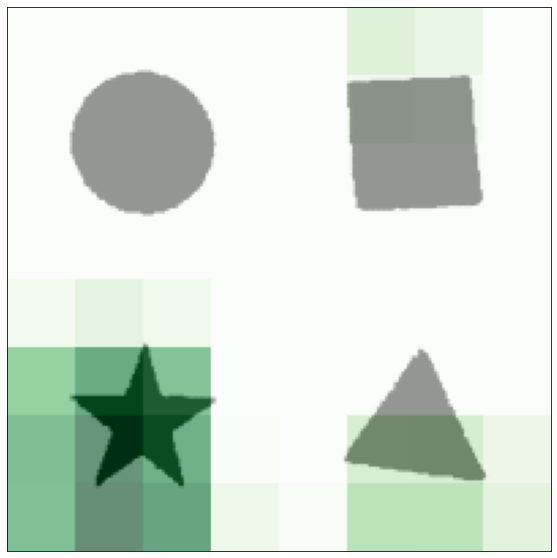

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.999999762, 'label': 'star', 'labelid': 2}, 1: {'probability': 2.07e-07, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


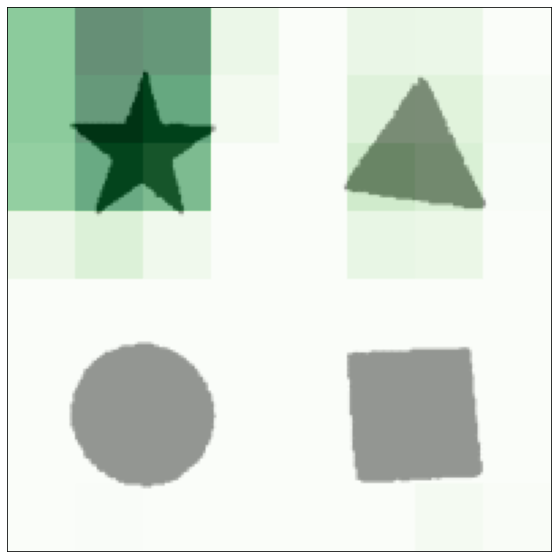

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.859172702, 'label': 'circle', 'labelid': 0}, 1: {'probability': 0.14076367, 'label': 'square', 'labelid': 1}, 2: {'probability': 6.3641e-05, 'label': 'triangle', 'labelid': 3}, 3: {'probability': 0.0, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(0, device='cuda:0')
target_label:  0


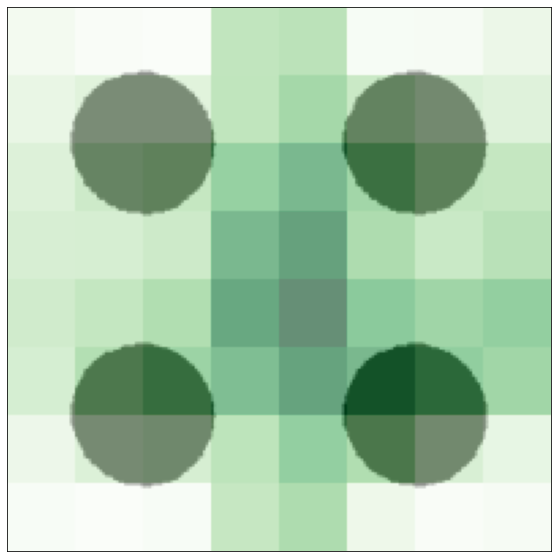

tensor(0, device='cuda:0') circle 0.86
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


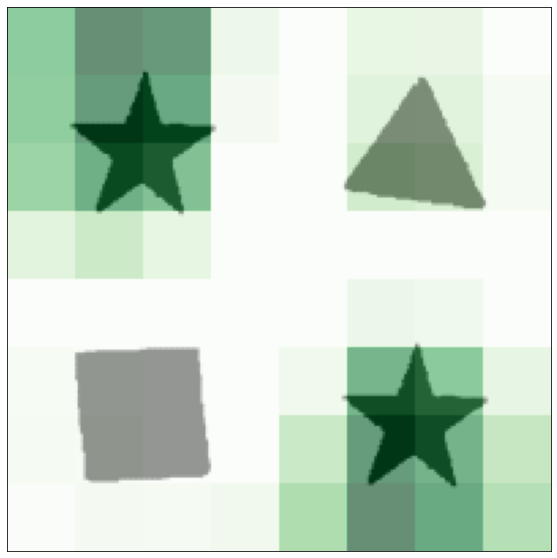

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.999994755, 'label': 'star', 'labelid': 2}, 1: {'probability': 5.189e-06, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


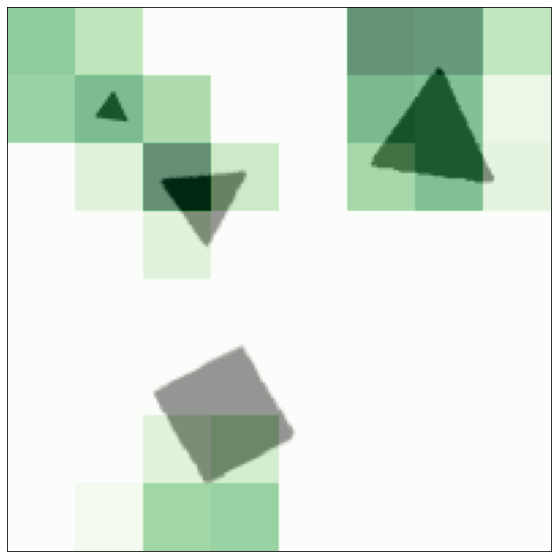

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.975271761, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.024728237, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


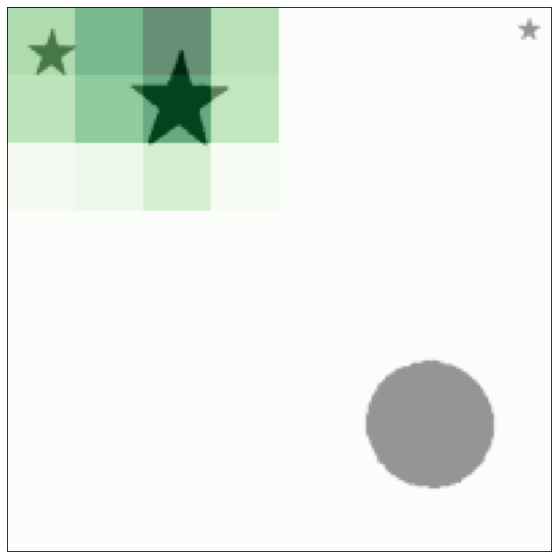

tensor(2, device='cuda:0') star 0.98
{0: {'probability': 0.966135323, 'label': 'square', 'labelid': 1}, 1: {'probability': 0.031918541, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.001945588, 'label': 'circle', 'labelid': 0}, 3: {'probability': 5.95e-07, 'label': 'star', 'labelid': 2}}
Selected label:  tensor(1, device='cuda:0')
target_label:  1


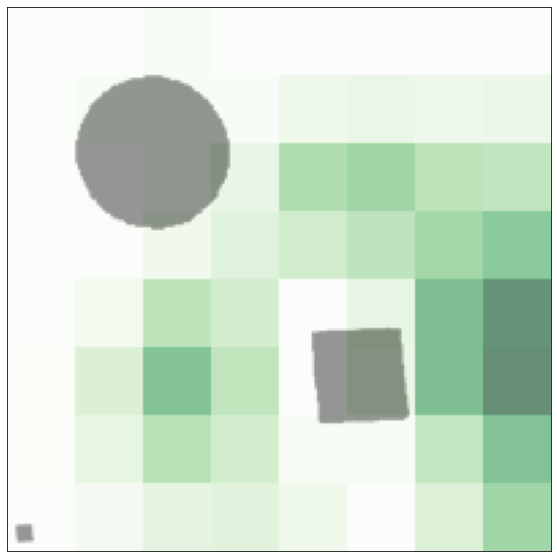

tensor(1, device='cuda:0') square 0.97
{0: {'probability': 1.0, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.0, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


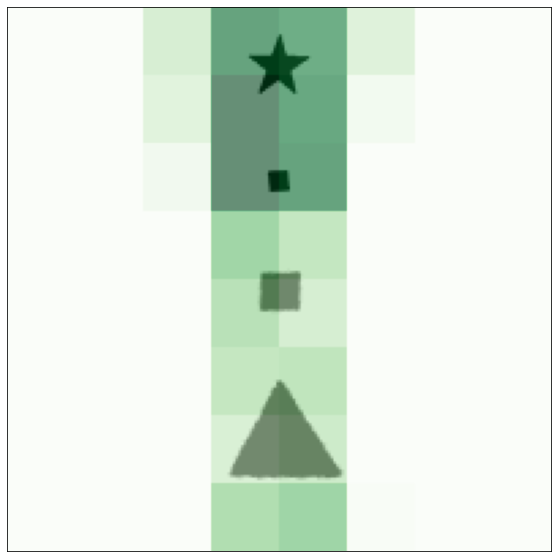

tensor(2, device='cuda:0') star 1.0
{0: {'probability': 0.998681962, 'label': 'star', 'labelid': 2}, 1: {'probability': 0.001317994, 'label': 'triangle', 'labelid': 3}, 2: {'probability': 0.0, 'label': 'square', 'labelid': 1}, 3: {'probability': 0.0, 'label': 'circle', 'labelid': 0}}
Selected label:  tensor(2, device='cuda:0')
target_label:  2


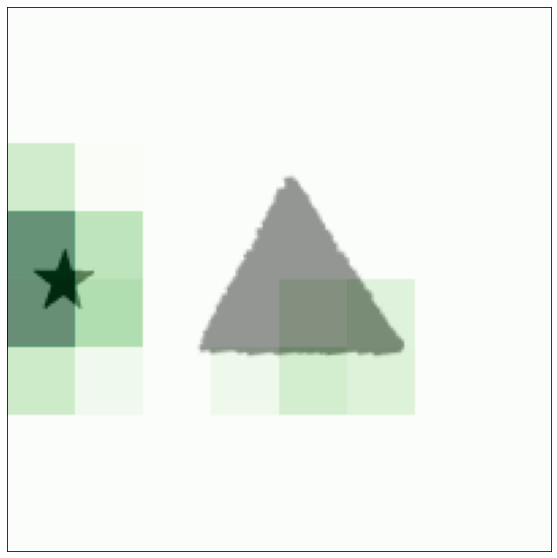

tensor(2, device='cuda:0') star 1.0


In [31]:
XAI_save_path="random_path"
run_experiment_shapes(model_ft, "/content/data/captum-shape-testset/set1/", "Set1 no_pret", XAI_save_path, 0, -1, False, True)
run_experiment_shapes(model_ft, "/content/data/captum-shape-testset/set2/", "Set2 no_pret", XAI_save_path, 0, -1, False, True)